In [1]:
import requests
import zipfile
import glob
import numpy as np
from pathlib import Path
import os

import matplotlib.pyplot as plt
from PIL import Image


import torch
from transformers import pipeline


In [ ]:
import kagglehub
from pathlib import Path
import shutil

dataset_id = "jessicali9530/celeba-dataset"

cache_dir = Path(kagglehub.dataset_download(dataset_id))
print("Downloaded to cache:", cache_dir)


project_data_dir = Path("..") / "data" / "celeba-dataset"
project_data_dir.parent.mkdir(parents=True, exist_ok=True)

if project_data_dir.exists():
    print("Project data dir already exists:", project_data_dir)
else:
    shutil.copytree(cache_dir, project_data_dir)
    print("Copied dataset to:", project_data_dir)


print("Some files:")
for p in sorted(project_data_dir.rglob("*"))[:20]:
    print(" -", p.relative_to(project_data_dir))


100%|██████████| 1.33G/1.33G [04:03<00:00, 5.87MB/s]

Extracting files...


Downloaded to cache: C:\Users\mengi\.cache\kagglehub\datasets\jessicali9530\celeba-dataset\versions\2
Copied dataset to: ..\data\celeba-dataset
Some files:
 - img_align_celeba
 - img_align_celeba\img_align_celeba
 - img_align_celeba\img_align_celeba\000001.jpg
 - img_align_celeba\img_align_celeba\000002.jpg
 - img_align_celeba\img_align_celeba\000003.jpg
 - img_align_celeba\img_align_celeba\000004.jpg
 - img_align_celeba\img_align_celeba\000005.jpg
 - img_align_celeba\img_align_celeba\000006.jpg
 - img_align_celeba\img_align_celeba\000007.jpg
 - img_align_celeba\img_align_celeba\000008.jpg
 - img_align_celeba\img_align_celeba\000009.jpg
 - img_align_celeba\img_align_celeba\000010.jpg
 - img_align_celeba\img_align_celeba\000011.jpg
 - img_align_celeba\img_align_celeba\000012.jpg
 - img_align_celeba\img_align_celeba\000013.jpg
 - img_align_celeba\img_align_celeba\000014.jpg
 - img_align_celeba\img_align_celeba\000015.jpg
 - img_align_celeba\img_align_celeba\000016.jpg
 - img_align_celeba

Load CLIP model


In [2]:
use_cuda = torch.cuda.is_available()
device = 0 if use_cuda else -1
device

0

In [3]:
clip = pipeline(task="zero-shot-image-classification", model="openai/clip-vit-base-patch32", dtype=torch.bfloat16, use_fast=True, device=0)
labels = ["a photo of a cat", "a photo of a dog", "a photo of a car"]
clip("http://images.cocodataset.org/val2017/000000039769.jpg", candidate_labels=labels)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Device set to use cuda:0


[{'score': 0.9921875, 'label': 'a photo of a cat'},
 {'score': 0.005889892578125, 'label': 'a photo of a car'},
 {'score': 0.0031585693359375, 'label': 'a photo of a dog'}]

In [4]:
import torch
from transformers import AutoProcessor, CLIPModel
from transformers.image_utils import load_image

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = AutoProcessor.from_pretrained("openai/clip-vit-base-patch32", use_fast=True)

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = load_image(url)

inputs = processor(text=["a photo of a cat", "a photo of a dog"], images=image, return_tensors="pt", padding=True)

with torch.inference_mode():
    outputs = model(**inputs)
logits_per_image = outputs.logits_per_image  # this is the image-text similarity score
probs = logits_per_image.softmax(dim=1)  # we can take the softmax to get the label probabilities

Import utility functions


In [ ]:
# Import our sampling utilities
import sys

sys.path.append("../scripts")
from sample_images import sample_celeba_images, sample_flickr_images, get_flickr_captions, load_images  # noqa

Sample Images


In [7]:
# Sample 300 images from Flickr8k
flickr_image_paths = sample_flickr_images(n=300, seed=42)
print(f"Sampled {len(flickr_image_paths)} images from Flickr8k")

# Show a few examples with their captions
print("\nExample images:")
for i, path in enumerate(flickr_image_paths[:3]):
    print(f"\n{i + 1}. {path.name}")
    captions = get_flickr_captions(path)
    for j, caption in enumerate(captions[:2], 1):  # Show first 2 captions
        print(f"   Caption {j}: {caption}")

Sampled 300 images from Flickr8k

Example images:

1. 3354489242_dd529ffa1f.jpg
   Caption 1: A goalie tries to block the puck in a hockey game .
   Caption 2: A hockey goalie stops the puck .

2. 2071309418_1d7580b0f0.jpg
   Caption 1: A white dog wearing a christmas reindeer headband plays with a brown dog in the grass among some stuffed animals .
   Caption 2: A white dog wearing reindeer ears is next to a brown dog .

3. 1247181182_35cabd76f3.jpg
   Caption 1: a man sits on a rock .
   Caption 2: A man sitting on a cliff in the mountains .


In [8]:
# Sample 300 images from CelebA
celeba_image_paths = sample_celeba_images(n=300, seed=42)
print(f"Sampled {len(celeba_image_paths)} images from CelebA")
print(f"Example paths: {[p.name for p in celeba_image_paths[:5]]}")

Sampled 300 images from CelebA
Example paths: ['003649.jpg', '000820.jpg', '009013.jpg', '008025.jpg', '007315.jpg']


### Extract CLIP Image Embeddings


In [9]:
from PIL import Image
from tqdm import tqdm


def extract_clip_embeddings(image_paths, model, processor, device="cuda", batch_size=32):
    """
    Extract CLIP image embeddings for a list of image paths.

    Args:
        image_paths: List of Path objects pointing to images
        model: CLIP model
        processor: CLIP processor
        device: Device to run on ('cuda' or 'cpu')
        batch_size: Number of images to process at once

    Returns:
        Tensor of shape (n_images, embedding_dim)
    """
    embeddings = []

    # Move model to device
    model = model.to(device)
    model.eval()

    # Process in batches
    for i in tqdm(range(0, len(image_paths), batch_size), desc="Extracting embeddings"):
        batch_paths = image_paths[i : i + batch_size]
        batch_images = [Image.open(path) for path in batch_paths]

        # Process images
        inputs = processor(images=batch_images, return_tensors="pt", padding=True)
        inputs = {k: v.to(device) for k, v in inputs.items()}

        # Extract embeddings
        with torch.inference_mode():
            image_features = model.get_image_features(**inputs)
            # Normalize embeddings
            image_features = image_features / image_features.norm(dim=-1, keepdim=True)

        embeddings.append(image_features.cpu())

    return torch.cat(embeddings, dim=0)

In [26]:
len(flickr_image_paths), len(celeba_image_paths)

(300, 300)

In [10]:
# Extract embeddings for Flickr8k images
print("Extracting embeddings for Flickr8k images...")
flickr_embeddings = extract_clip_embeddings(flickr_image_paths, model, processor, device="cuda" if torch.cuda.is_available() else "cpu", batch_size=32)
print(f"Flickr embeddings shape: {flickr_embeddings.shape}")

# Extract embeddings for CelebA images
print("\nExtracting embeddings for CelebA images...")
celeba_embeddings = extract_clip_embeddings(celeba_image_paths, model, processor, device="cuda" if torch.cuda.is_available() else "cpu", batch_size=32)
print(f"CelebA embeddings shape: {celeba_embeddings.shape}")

Extracting embeddings for Flickr8k images...


Extracting embeddings: 100%|██████████| 10/10 [00:04<00:00,  2.11it/s]


Flickr embeddings shape: torch.Size([300, 512])

Extracting embeddings for CelebA images...


Extracting embeddings: 100%|██████████| 10/10 [00:03<00:00,  2.73it/s]

CelebA embeddings shape: torch.Size([300, 512])


### Baseline Text-Query Retrieval

text-query retrieval using cosine similarity between text and image embeddings.


In [11]:
def text_query_retrieval(query_text, image_embeddings, image_paths, model, processor, k=10, device="cuda"):
    """
    Retrieve top-k images based on a text query.

    Args:
        query_text: Text query (e.g., "a photo of a dog")
        image_embeddings: Precomputed image embeddings (n_images, embedding_dim)
        image_paths: List of image paths corresponding to embeddings
        model: CLIP model
        processor: CLIP processor
        k: Number of top results to return
        device: Device to run on

    Returns:
        List of tuples (image_path, similarity_score) for top-k matches
    """
    model = model.to(device)
    model.eval()

    # Encode the text query
    text_inputs = processor(text=[query_text], return_tensors="pt", padding=True)
    text_inputs = {k: v.to(device) for k, v in text_inputs.items()}

    with torch.inference_mode():
        text_features = model.get_text_features(**text_inputs)
        # Normalize
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)

    # Compute cosine similarity
    image_embeddings_device = image_embeddings.to(device)
    similarities = (text_features @ image_embeddings_device.T).squeeze(0)

    # Get top-k indices
    top_k_indices = similarities.argsort(descending=True)[:k]

    # Prepare results
    results = [(image_paths[idx], similarities[idx].item()) for idx in top_k_indices.cpu()]

    return results

In [12]:
# Test text-query retrieval on Flickr8k
query = "a dog playing in the park"
print(f"Query: '{query}'")
print("\nTop-10 results from Flickr8k:")

results = text_query_retrieval(query, flickr_embeddings, flickr_image_paths, model, processor, k=10, device="cuda" if torch.cuda.is_available() else "cpu")

for i, (path, score) in enumerate(results, 1):
    print(f"{i}. {path.name} (similarity: {score:.4f})")
    # Show first caption for context
    captions = get_flickr_captions(path)
    if captions:
        print(f"   Caption: {captions[0]}")

Query: 'a dog playing in the park'

Top-10 results from Flickr8k:
1. 2180480870_dcaf5ac0df.jpg (similarity: 0.3237)
   Caption: A brown dog is about to jump .
2. 2460159430_71ab1aacfa.jpg (similarity: 0.3098)
   Caption: A brown dog races through a field .
3. 2444821454_22a346c996.jpg (similarity: 0.3054)
   Caption: A black and white dog is in the grass with a red striped disk .
4. 1072153132_53d2bb1b60.jpg (similarity: 0.3037)
   Caption: A black and white dog catches a toy in midair .
5. 458183774_afe65abf67.jpg (similarity: 0.2941)
   Caption: A dog rolls on his back in the grass .
6. 2404692474_37da774368.jpg (similarity: 0.2930)
   Caption: A dog chasing a toy duck .
7. 2256218522_53b92bcbb2.jpg (similarity: 0.2922)
   Caption: A black and white dog is running through the sand at a beach .
8. 3564157681_03a13b7112.jpg (similarity: 0.2897)
   Caption: A dog catches a yellow Frisbee thrown by a gray-haired man .
9. 69189650_6687da7280.jpg (similarity: 0.2875)
   Caption: A brown do

### Visualize Results

visualize the top-k retrieved images.


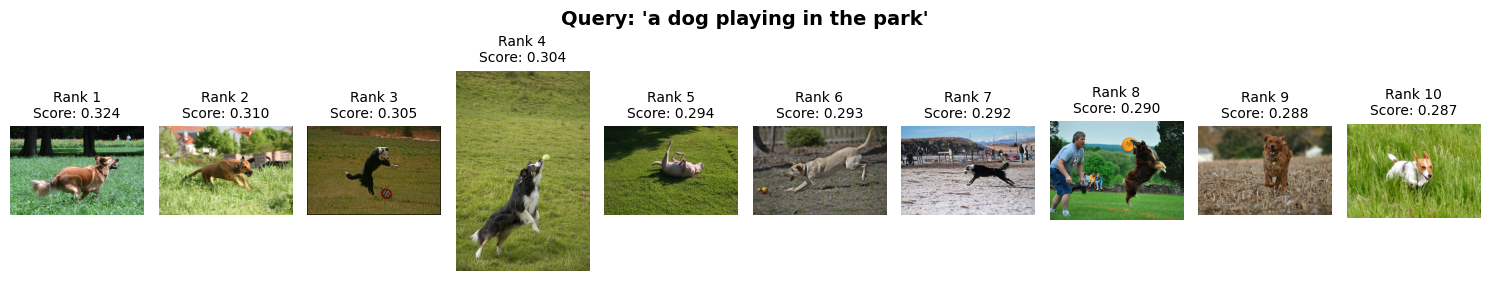

In [ ]:
def visualize_retrieval_results(results, query_text, n_show=5, figsize=(15, 3)):
    n_show = min(n_show, len(results))
    fig, axes = plt.subplots(1, n_show, figsize=figsize)
    if n_show == 1:
        axes = [axes]

    fig.suptitle(f"Query: '{query_text}'", fontsize=14, fontweight="bold")

    for i, (path, score) in enumerate(results[:n_show]):
        img = Image.open(path)
        axes[i].imshow(img)
        axes[i].axis("off")
        axes[i].set_title(f"Rank {i + 1}\nScore: {score:.3f}", fontsize=10)

    plt.tight_layout()
    plt.show()


visualize_retrieval_results(results, query, n_show=10)

### Manual Relevance Labeling and Precision@k


In [ ]:
def compute_precision_at_k(relevance_labels, k=None):
    """
    Compute Precision@k given binary relevance labels.

    Args:
        relevance_labels: List of binary labels (1=relevant, 0=not relevant) in rank order
        k: Number of top results to consider (default: all)

    Returns:
        Precision@k score
    """
    if k is None:
        k = len(relevance_labels)
    else:
        k = min(k, len(relevance_labels))

    relevant_count = sum(relevance_labels[:k])
    precision = relevant_count / k
    return precision


# Manually label the top-10 results for the query "a dog playing in the park"
# After viewing the images, you would assign 1 (relevant) or 0 (not relevant)
# TODO: View the images above and manually label each as relevant (1) or not (0). DO this again eveytime the images are re-generated or the query is changed.
manual_labels = [1, 1, 1, 1, 1, 0, 0, 1, 0, 1]

# Compute Precision@k for different k values
print("Precision@k for query: 'a dog playing in the park'")
for k in [1, 3, 5, 10]:
    p_at_k = compute_precision_at_k(manual_labels, k=k)
    print(f"  Precision@{k}: {p_at_k:.3f}")

Precision@k for query: 'a dog playing in the park'
  Precision@1: 1.000
  Precision@3: 1.000
  Precision@5: 1.000
  Precision@10: 0.700


### Save Embeddings and Results


Saved embeddings to ..\data\task1_outputs\clip_embeddings.pt


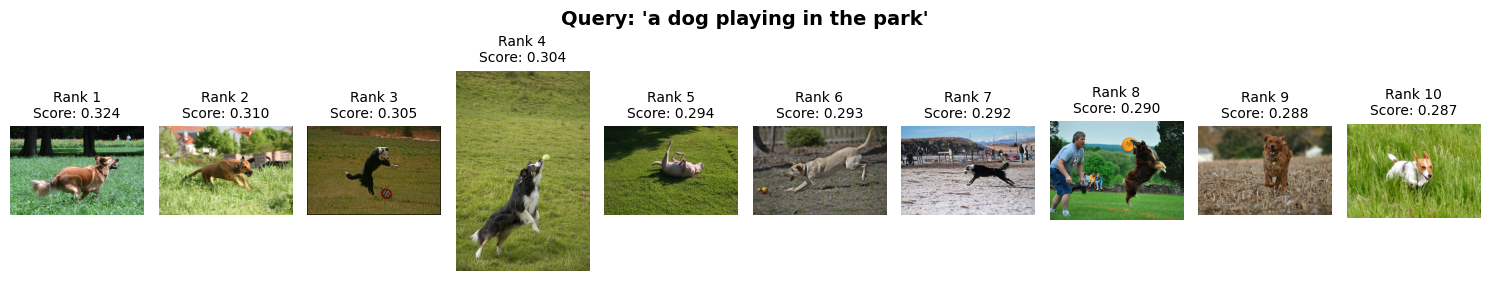

  Saved top-20 results for: 'a dog playing in the park'


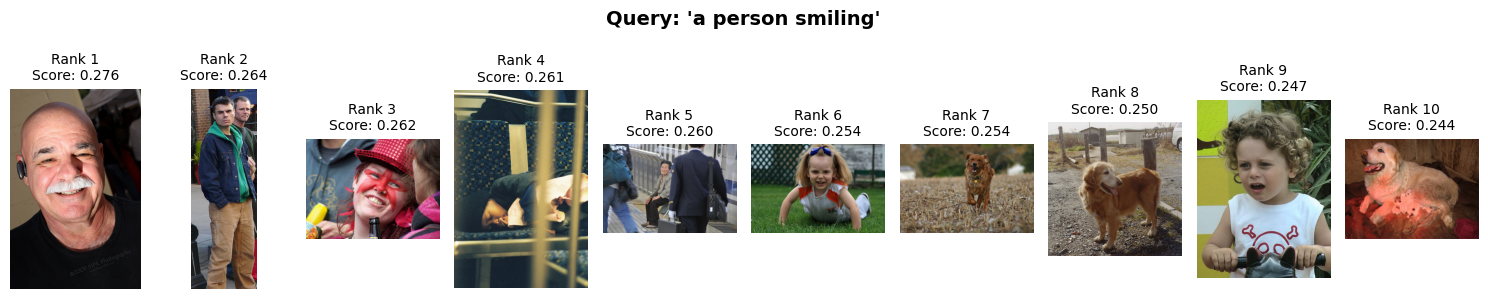

  Saved top-20 results for: 'a person smiling'


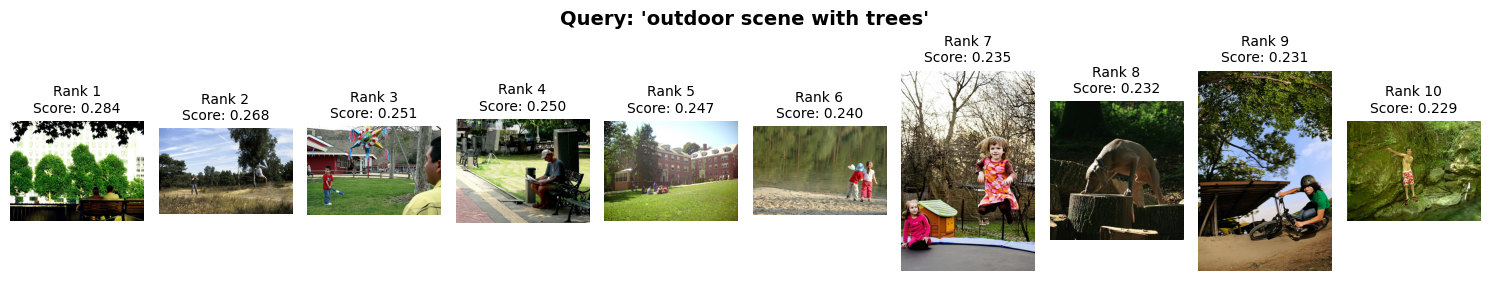

  Saved top-20 results for: 'outdoor scene with trees'


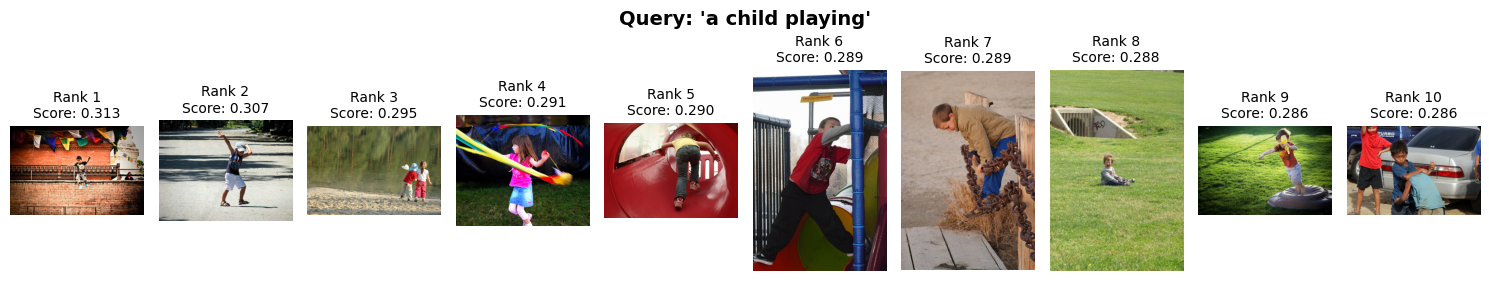

  Saved top-20 results for: 'a child playing'


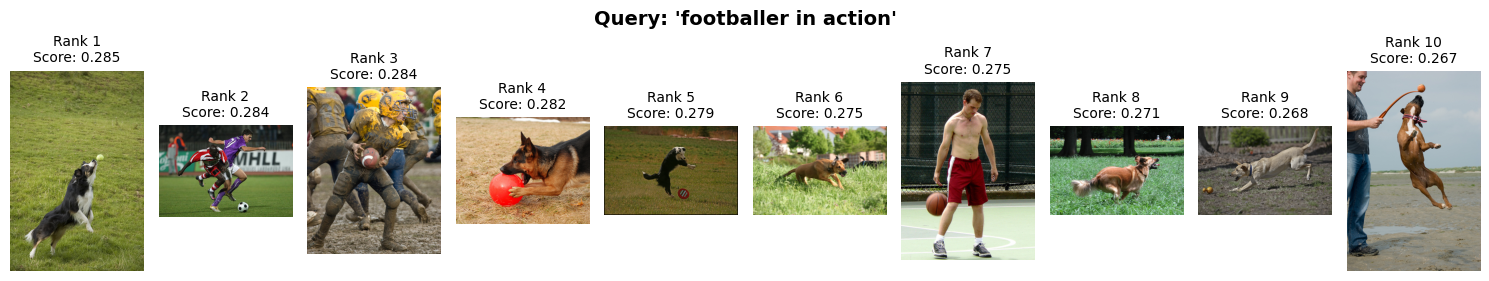

  Saved top-20 results for: 'footballer in action'


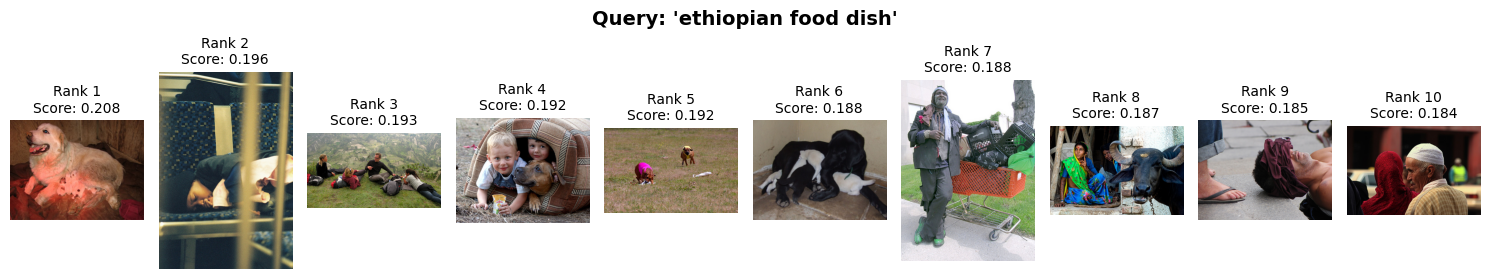

  Saved top-20 results for: 'ethiopian food dish'


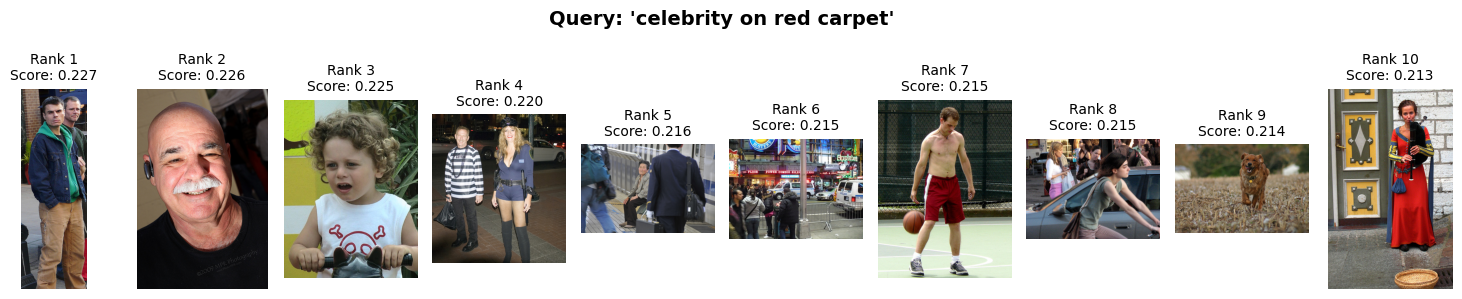

  Saved top-20 results for: 'celebrity on red carpet'


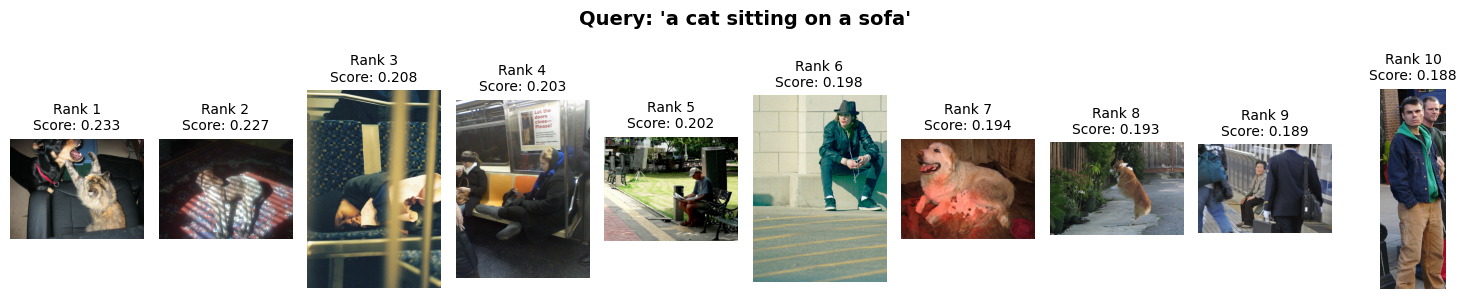

  Saved top-20 results for: 'a cat sitting on a sofa'


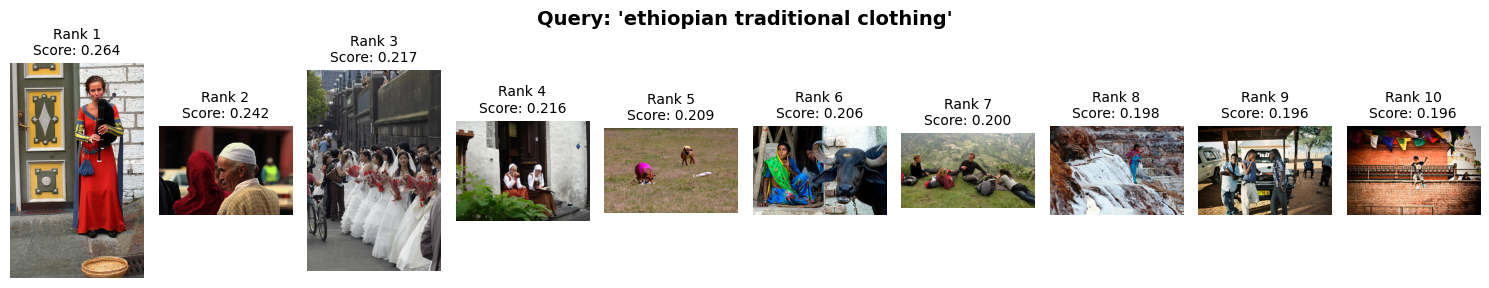

  Saved top-20 results for: 'ethiopian traditional clothing'


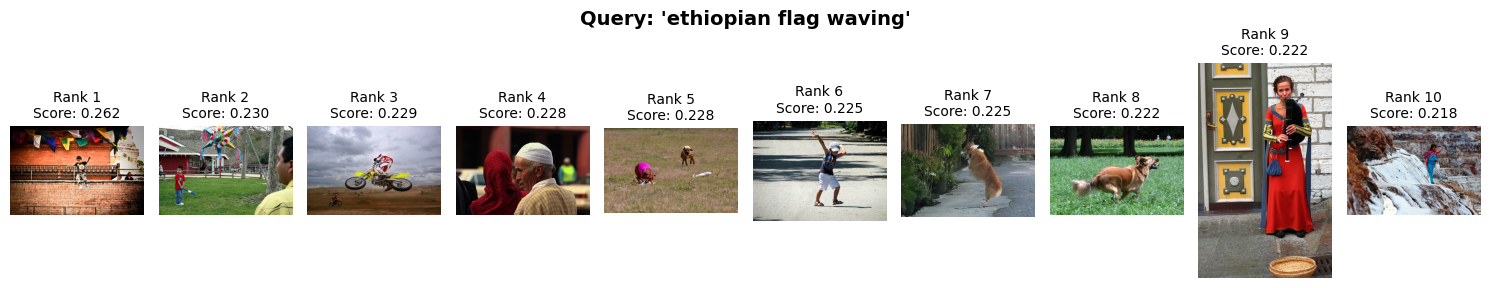

  Saved top-20 results for: 'ethiopian flag waving'


In [ ]:
import pickle


# output directory
output_dir = Path("../data/task1_outputs")
output_dir.mkdir(exist_ok=True, parents=True)

# Save embeddings
torch.save(
    {
        "flickr_embeddings": flickr_embeddings,
        "celeba_embeddings": celeba_embeddings,
        "flickr_paths": flickr_image_paths,
        "celeba_paths": celeba_image_paths,
    },
    output_dir / "clip_embeddings.pt",
)

print(f"Saved embeddings to {output_dir / 'clip_embeddings.pt'}")

# Save top-k results for a few queries
sample_queries = [
    "a dog playing in the park",
    "a person smiling",
    "outdoor scene with trees",
    "a child playing",
    "footballer in action",
    "ethiopian food dish",
    "celebrity on red carpet",
    "a cat sitting on a sofa",
    "ethiopian traditional clothing",
    "ethiopian flag waving",
]

all_results = {}
for query in sample_queries:
    results = text_query_retrieval(query, flickr_embeddings, flickr_image_paths, model, processor, k=20, device="cuda" if torch.cuda.is_available() else "cpu")
    visualize_retrieval_results(results, query, n_show=10)
    all_results[query] = results
    print(f"  Saved top-20 results for: '{query}'")

# Save results
with open(output_dir / "baseline_retrieval_results.pkl", "wb") as f:
    pickle.dump(all_results, f)
